# Курсовой проект по курсу "Python для DataScience часть 2"

## Импорт библиотек

In [50]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import Markdown as md

import seaborn as sns

In [51]:
test_path = 'course_project_test.csv'
train_path = 'course_project_train.csv'

## Построение модели классификации

### 1. Обзор обучающего датасета

In [52]:
df_train = pd.read_csv(train_path)
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [53]:
df_train.shape

(7500, 17)

Видим, что имеется 7500 наблюдений и 17 признаков, из них один признак - Credit Default - целевой.

In [54]:
df_train.iloc[0]

Home Ownership                            Own Home
Annual Income                               482087
Years in current job                           NaN
Tax Liens                                        0
Number of Open Accounts                         11
Years of Credit History                       26.3
Maximum Open Credit                         685960
Number of Credit Problems                        1
Months since last delinquent                   NaN
Bankruptcies                                     1
Purpose                         debt consolidation
Term                                    Short Term
Current Loan Amount                          1e+08
Current Credit Balance                       47386
Monthly Debt                                  7914
Credit Score                                   749
Credit Default                                   0
Name: 0, dtype: object

Описание датасета:

    Home Ownership - домовладение,
    Annual Income - годовой доход,
    Years in current job - количество лет на текущем месте работы,
    Tax Liens - налоговые обременения,
    Number of Open Accounts - количество открытых счетов,
    Years of Credit History - количество лет кредитной истории,
    Maximum Open Credit - наибольший открытый кредит,
    Number of Credit Problems - количество проблем с кредитом,
    Months since last delinquent - количество месяцев с последней просрочки платежа,
    Bankruptcies - банкротства,
    Purpose - цель кредита,
    Term - срок кредита,
    Current Loan Amount - текущая сумма кредита,
    Current Credit Balance - текущий кредитный баланс,
    Monthly Debt - ежемесячный долг,
    Credit Default - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [55]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
Home Ownership                  7500 non-null object
Annual Income                   5943 non-null float64
Years in current job            7129 non-null object
Tax Liens                       7500 non-null float64
Number of Open Accounts         7500 non-null float64
Years of Credit History         7500 non-null float64
Maximum Open Credit             7500 non-null float64
Number of Credit Problems       7500 non-null float64
Months since last delinquent    3419 non-null float64
Bankruptcies                    7486 non-null float64
Purpose                         7500 non-null object
Term                            7500 non-null object
Current Loan Amount             7500 non-null float64
Current Credit Balance          7500 non-null float64
Monthly Debt                    7500 non-null float64
Credit Score                    5943 non-null float64
Credit Default                  7

Видим (там, где менее 7500), что есть пропуски. Это касается 'Annual Income', т.е. не у всех известен годовой доход. Что касается поля 'Month since last delinquent', то пропуски (NaN) можно заменить большим числом (фактически не было правонарушений). Таким числом может быть практически бесконечный срок кредита - 50 лет (600 месяцев).

In [56]:
df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


В целом, каких-то заоблачных значений нет, за исключением, возможно, суммы наибольшего открытого кредита кредита около 1300 млн. руб или текущей суммы кредита около 100 млн. руб. Из таблицы видно, что среднее значение 'Current Default' равно 0.28, что говорит о несбалансированности выборки (в данной выборке "дефолтников" около 28%).

### 2. Обработка выбросов

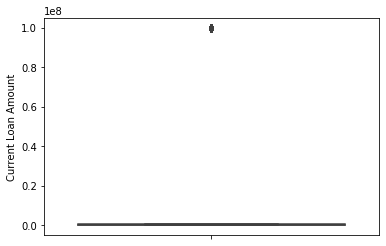

In [57]:
col_name = 'Current Loan Amount'
ax = sns.boxplot(y = df_train[col_name])

Путем перебора выясняем, что подозрительным является значение "все девятки"

In [58]:
val = 99999999
sum(df_train[col_name] == val)

870

Посмотрим на статистику данных в этом подозрительном разрезе

In [59]:
df_train[df_train[col_name] == val][set(df_train.columns) - {col_name}].describe()

,Tax Liens,Maximum Open Credit,Annual Income,Number of Credit Problems,Monthly Debt,Credit Default,Credit Score,Number of Open Accounts,Bankruptcies,Current Credit Balance,Months since last delinquent,Years of Credit History
count,870.000000,8.700000e+02,8.700000e+02,870.000000,870.000000,870.0,870.000000,870.000000,867.000000,8.700000e+02,371.000000,870.000000
mean,0.024138,8.373678e+05,1.427779e+06,0.158621,17933.028736,0.0,730.225287,11.134483,0.111880,3.028599e+05,34.730458,18.509080
std,0.259443,2.096922e+06,8.998839e+05,0.465261,12264.380264,0.0,21.395230,4.803056,0.336652,3.590877e+05,21.185732,7.024222
min,0.000000,0.000000e+00,2.167140e+05,0.000000,0.000000,0.0,601.000000,2.000000,0.000000,0.000000e+00,0.000000,4.800000
25%,0.000000,3.001625e+05,8.668560e+05,0.000000,9484.750000,0.0,726.000000,8.000000,0.000000,1.145225e+05,18.000000,13.725000
50%,0.000000,5.155040e+05,1.245507e+06,0.000000,15445.500000,0.0,737.000000,10.000000,0.000000,2.134650e+05,32.000000,17.200000
75%,0.000000,8.601725e+05,1.726886e+06,0.000000,23421.250000,0.0,744.000000,14.000000,0.000000,3.633702e+05,50.000000,22.350000
max,6.000000,4.092389e+07,8.758449e+06,6.000000,94674.000000,0.0,751.000000,34.000000,3.000000,4.249673e+06,81.000000,50.900000


Видим, что это "недефолтники" (max и min 'Credit Default' равны 0), а так как недефолтников в выборке больше, то удаление части их не так страшно (тех, у которых подозрительное значение 'Current Loan Amount' 99999999).

Проверим признак 'Maximum Open Credit'

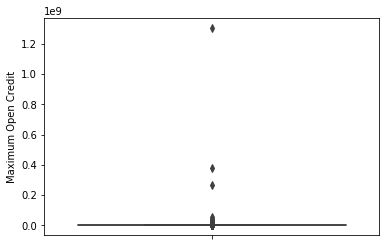

In [60]:
col_name = 'Maximum Open Credit'
ax = sns.boxplot(y = df_train[col_name])

In [61]:
val = 1304726170
sum(df_train[col_name] == val)

1

In [62]:
df_train[df_train[col_name] == val][set(df_train.columns) - {col_name}]

,Tax Liens,Annual Income,Number of Credit Problems,Monthly Debt,Term,Credit Default,Years in current job,Credit Score,Number of Open Accounts,Bankruptcies,Home Ownership,Current Credit Balance,Current Loan Amount,Purpose,Months since last delinquent,Years of Credit History
617,0.0,NaN,0.0,5492.0,Short Term,0,3 years,NaN,13.0,0.0,Home Mortgage,1126814.0,529892.0,debt consolidation,NaN,27.5


Ничего особенного, но так как такое значение одно, то принимаем это за выброс и удаляем.

In [63]:
df_train = df_train.drop(df_train[df_train[col_name] == val].index)

In [64]:
val = 380052288
sum(df_train[col_name] == val)

1

In [65]:
df_train[df_train[col_name] == val][set(df_train.columns) - {col_name}]

,Tax Liens,Annual Income,Number of Credit Problems,Monthly Debt,Term,Credit Default,Years in current job,Credit Score,Number of Open Accounts,Bankruptcies,Home Ownership,Current Credit Balance,Current Loan Amount,Purpose,Months since last delinquent,Years of Credit History
44,0.0,1334256.0,1.0,34357.0,Short Term,0,10+ years,729.0,17.0,0.0,Have Mortgage,656450.0,33110.0,take a trip,35.0,15.4


Ничего особенного. Опять удаляем выброс.

In [66]:
df_train = df_train.drop(df_train[df_train[col_name] == val].index)

In [67]:
val = 265512874
sum(df_train[col_name] == val)

1

In [68]:
df_train[df_train[col_name] == val][set(df_train.columns) - {col_name}]

,Tax Liens,Annual Income,Number of Credit Problems,Monthly Debt,Term,Credit Default,Years in current job,Credit Score,Number of Open Accounts,Bankruptcies,Home Ownership,Current Credit Balance,Current Loan Amount,Purpose,Months since last delinquent,Years of Credit History
2617,0.0,3217802.0,0.0,20272.0,Short Term,0,10+ years,750.0,12.0,0.0,Home Mortgage,1834450.0,50116.0,other,NaN,35.5


Ничего особенного.
Итого: удаляем наблюдения, у которых признак 'Current Loan Amount' равен 99999999.

In [69]:
df_train = df_train.drop(df_train[df_train[col_name] == val].index)

In [70]:
col_name = 'Current Loan Amount'
val = 99999999
df_train = df_train.drop(df_train[df_train[col_name] == val].index)

In [71]:
df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.071000e+03,6627.000000,6627.000000,6627.000000,6.627000e+03,6627.000000,3047.000000,6616.000000,6627.000000,6.627000e+03,6627.000000,5071.000000,6627.000000
mean,1.355501e+06,0.030934,11.129169,18.288773,6.654371e+05,0.171420,34.687890,0.117896,309071.765505,2.877084e+05,18363.746793,1223.454545,0.318847
std,8.350231e+05,0.273229,4.923524,7.041834,1.107517e+06,0.502824,21.756216,0.348638,182255.811109,3.113375e+05,11881.779310,1726.626749,0.466065
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,11242.000000,0.000000e+00,0.000000,585.000000,0.000000
25%,8.396005e+05,0.000000,8.000000,13.500000,2.764850e+05,0.000000,16.000000,0.000000,172821.000000,1.141615e+05,10153.500000,709.000000,0.000000
50%,1.162344e+06,0.000000,10.000000,17.000000,4.734840e+05,0.000000,32.000000,0.000000,265826.000000,2.089430e+05,16202.000000,730.000000,0.000000
75%,1.627492e+06,0.000000,14.000000,21.800000,7.841240e+05,0.000000,50.000000,0.000000,430100.000000,3.587960e+05,23880.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,5.756256e+07,7.000000,118.000000,4.000000,789030.000000,6.506797e+06,136679.000000,7510.000000,1.000000


Видим, что баланс выборки несколько улучшился (32% дефолтников), но ценой удаления 870 наблюдений (12%).

### 3. Обработка пропусков

Как уже говорилось ранее, заменим NaN в признаке 'Months since last delinquent' на 600 месяцев.

In [73]:
col_name = 'Months since last delinquent'
val = 600
df_train[col_name].fillna(val, inplace = True)

In [74]:
df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.071000e+03,6627.000000,6627.000000,6627.000000,6.627000e+03,6627.000000,6627.000000,6616.000000,6627.000000,6.627000e+03,6627.000000,5071.000000,6627.000000
mean,1.355501e+06,0.030934,11.129169,18.288773,6.654371e+05,0.171420,340.077561,0.117896,309071.765505,2.877084e+05,18363.746793,1223.454545,0.318847
std,8.350231e+05,0.273229,4.923524,7.041834,1.107517e+06,0.502824,282.147481,0.348638,182255.811109,3.113375e+05,11881.779310,1726.626749,0.466065
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,11242.000000,0.000000e+00,0.000000,585.000000,0.000000
25%,8.396005e+05,0.000000,8.000000,13.500000,2.764850e+05,0.000000,35.000000,0.000000,172821.000000,1.141615e+05,10153.500000,709.000000,0.000000
50%,1.162344e+06,0.000000,10.000000,17.000000,4.734840e+05,0.000000,600.000000,0.000000,265826.000000,2.089430e+05,16202.000000,730.000000,0.000000
75%,1.627492e+06,0.000000,14.000000,21.800000,7.841240e+05,0.000000,600.000000,0.000000,430100.000000,3.587960e+05,23880.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,5.756256e+07,7.000000,600.000000,4.000000,789030.000000,6.506797e+06,136679.000000,7510.000000,1.000000


NaN в признаке 'Annual Income' заменим условной медианой (условной, т.е. зависящей от 'Credit Default').

In [87]:
print(df_train[df_train['Credit Default'] == 0]['Annual Income'].median())
print(df_train[df_train['Credit Default'] == 1]['Annual Income'].median())

1221415.0
1055915.5


In [89]:
col_name = 'Annual Income'
val_0 = df_train[df_train['Credit Default'] == 0][col_name].median()
val_1 = df_train[df_train['Credit Default'] == 0][col_name].median()
df_train.loc[df_train['Credit Default'] == 0, col_name] = df_train.loc[df_train['Credit Default'] == 0, col_name].fillna(val_0)
df_train.loc[df_train['Credit Default'] == 1, col_name] = df_train.loc[df_train['Credit Default'] == 1, col_name].fillna(val_1)

In [90]:
df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,6.627000e+03,6627.000000,6627.000000,6627.000000,6.627000e+03,6627.000000,6627.000000,6616.000000,6627.000000,6.627000e+03,6627.000000,5071.000000,6627.000000
mean,1.324018e+06,0.030934,11.129169,18.288773,6.654371e+05,0.171420,340.077561,0.117896,309071.765505,2.877084e+05,18363.746793,1223.454545,0.318847
std,7.326351e+05,0.273229,4.923524,7.041834,1.107517e+06,0.502824,282.147481,0.348638,182255.811109,3.113375e+05,11881.779310,1726.626749,0.466065
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,11242.000000,0.000000e+00,0.000000,585.000000,0.000000
25%,9.370610e+05,0.000000,8.000000,13.500000,2.764850e+05,0.000000,35.000000,0.000000,172821.000000,1.141615e+05,10153.500000,709.000000,0.000000
50%,1.221415e+06,0.000000,10.000000,17.000000,4.734840e+05,0.000000,600.000000,0.000000,265826.000000,2.089430e+05,16202.000000,730.000000,0.000000
75%,1.458488e+06,0.000000,14.000000,21.800000,7.841240e+05,0.000000,600.000000,0.000000,430100.000000,3.587960e+05,23880.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,5.756256e+07,7.000000,600.000000,4.000000,789030.000000,6.506797e+06,136679.000000,7510.000000,1.000000


Видим, что не обработан признак 'Bankruptcies'.

In [91]:
col_name = 'Bankruptcies'
df_train[pd.isnull(df_train[col_name])][set(df_train.columns) - set(col_name)]

,Tax Liens,Maximum Open Credit,Current Credit Balance,Home Ownership,Current Loan Amount,Annual Income,Number of Credit Problems,Monthly Debt,Term,Credit Default,Years in current job,Credit Score,Number of Open Accounts,Purpose,Months since last delinquent,Bankruptcies,Years of Credit History
257,0.0,1556390.0,524210.0,Home Mortgage,447480.0,1221415.0,0.0,19613.0,Short Term,0,2 years,NaN,15.0,debt consolidation,0.0,NaN,13.6
898,0.0,2177758.0,607487.0,Rent,456808.0,739005.0,0.0,9669.0,Short Term,1,2 years,732.0,20.0,debt consolidation,0.0,NaN,18.3
1404,0.0,0.0,0.0,Rent,11242.0,349391.0,0.0,1243.0,Short Term,0,< 1 year,747.0,4.0,other,0.0,NaN,12.7
3063,0.0,38126.0,18373.0,Rent,44814.0,464474.0,0.0,929.0,Short Term,1,10+ years,7490.0,5.0,other,0.0,NaN,14.9
3252,0.0,636856.0,52250.0,Rent,156970.0,832770.0,0.0,1145.0,Short Term,0,< 1 year,750.0,7.0,business loan,0.0,NaN,16.5
3351,0.0,792836.0,625157.0,Home Mortgage,528968.0,2226192.0,0.0,23746.0,Short Term,0,8 years,674.0,14.0,debt consolidation,73.0,NaN,23.3
3496,0.0,0.0,0.0,Rent,210166.0,233567.0,0.0,0.0,Short Term,0,1 year,746.0,7.0,educational expenses,0.0,NaN,11.7
4334,0.0,575124.0,152988.0,Rent,167882.0,772749.0,0.0,7792.0,Short Term,0,< 1 year,729.0,9.0,debt consolidation,19.0,NaN,19.6
5566,0.0,594594.0,126331.0,Own Home,92620.0,1221415.0,0.0,11987.0,Short Term,0,< 1 year,NaN,12.0,other,0.0,NaN,24.7
7184,0.0,11132.0,8797.0,Rent,46706.0,240122.0,0.0,2881.0,Short Term,1,< 1 year,7060.0,3.0,debt consolidation,0.0,NaN,12.9


Удаляем эти наблюдения.

In [92]:
df_train.dropna(subset = [col_name], inplace = True)

In [93]:
df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,6.616000e+03,6616.000000,6616.000000,6616.000000,6.616000e+03,6616.000000,6616.000000,6616.000000,6616.000000,6.616000e+03,6616.000000,5062.000000,6616.000000
mean,1.324921e+06,0.030985,11.130744,18.291868,6.655611e+05,0.171705,340.629081,0.117896,309247.848247,2.878586e+05,18381.891173,1220.476096,0.318773
std,7.325376e+05,0.273453,4.922712,7.045092,1.108088e+06,0.503194,282.055946,0.348638,182211.088327,3.114163e+05,11879.133930,1721.856262,0.466036
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,21472.000000,0.000000e+00,0.000000,585.000000,0.000000
25%,9.381012e+05,0.000000,8.000000,13.500000,2.765565e+05,0.000000,35.000000,0.000000,173052.000000,1.143088e+05,10177.500000,709.000000,0.000000
50%,1.221415e+06,0.000000,10.000000,17.000000,4.734730e+05,0.000000,600.000000,0.000000,265870.000000,2.091900e+05,16223.000000,730.000000,0.000000
75%,1.458886e+06,0.000000,14.000000,21.800000,7.840030e+05,0.000000,600.000000,0.000000,430100.000000,3.587770e+05,23886.500000,742.750000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,5.756256e+07,7.000000,600.000000,4.000000,789030.000000,6.506797e+06,136679.000000,7510.000000,1.000000


Остался признак 'Credit Score'. Посмотрим на его значимость (корреляцию с другими, в т.ч с целевой переменной)

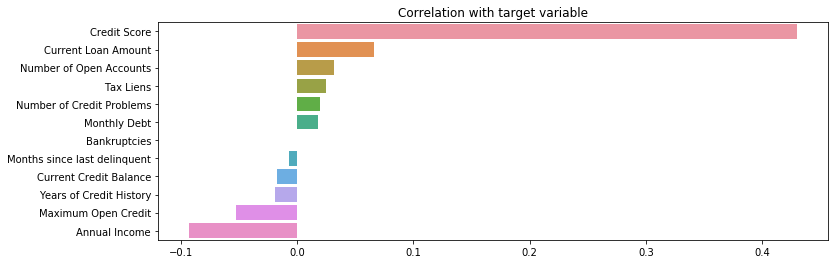

In [94]:
corr_with_target = df_train.corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(12, 4))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

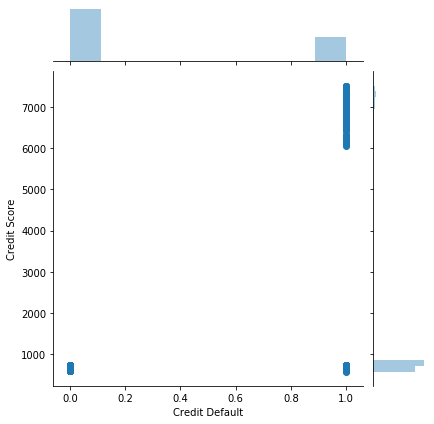

In [156]:
col_name = 'Credit Default'
with_name = 'Credit Score'
df_tmp = df_train.copy()
df_tmp.dropna(subset = [with_name], inplace = True)
limit_bal_with_target_s = df_tmp[[with_name, col_name]]

sns.jointplot(x = col_name, y = with_name, data = limit_bal_with_target_s)
plt.show()

Видим, что 'Credit Score' в данном случае антирейтинг, т.е. если он большой (более 5000), то для данной выборки всегда следует дефолт. Если score менее 5000, то возможно два исхода, причем чаще нет дефолта.

In [182]:
col_name = 'Credit Score'
threshold = 5000
print(sum((df_train[col_name] > threshold)))
print(sum((df_train[col_name] < threshold)))

397
4665


Вероятность дефолта при score менее порога

In [159]:
p1_down = sum((df_train[col_name] < threshold) & (df_train['Credit Default'] == 1)) / sum((df_train[col_name] < threshold))
print(format(p1_down, '.2f'))

0.25


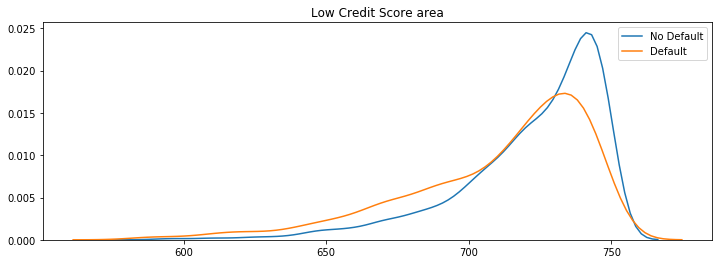

In [177]:
plt.figure(figsize=(12, 4))
sns.kdeplot(df_tmp.loc[(df_tmp['Credit Default'] == 0) & (df_train[col_name] < threshold), col_name], label = 'No Default')
sns.kdeplot(df_tmp.loc[(df_tmp['Credit Default'] == 1) & (df_train[col_name] < threshold), col_name], label = 'Default')

plt.title('Low Credit Score area')
plt.show()

Видим, что в нижней области рейтинга score его влияние правдоподобно: чем меньше в среднем рейтинг, тем выше вероятность дефолта (кривая 'Default' смещена левее кривой 'No Default'). Поэтому удалять рейтинг не стоит, а пропущенные значения стоит заменить на условную медиану.

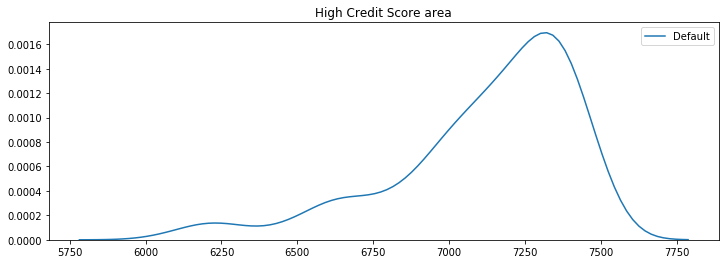

In [183]:
plt.figure(figsize=(12, 4))
sns.kdeplot(df_tmp.loc[(df_tmp['Credit Default'] == 0) & (df_train[col_name] > threshold), col_name], label = 'No Default')
sns.kdeplot(df_tmp.loc[(df_tmp['Credit Default'] == 1) & (df_train[col_name] > threshold), col_name], label = 'Default')

plt.title('High Credit Score area')
plt.show()

In [184]:
col_name = 'Credit Score'
val_0 = df_train[df_train['Credit Default'] == 0][col_name].median()
val_1 = df_train[df_train['Credit Default'] == 0][col_name].median()
df_train.loc[df_train['Credit Default'] == 0, col_name] = df_train.loc[df_train['Credit Default'] == 0, col_name].fillna(val_0)
df_train.loc[df_train['Credit Default'] == 1, col_name] = df_train.loc[df_train['Credit Default'] == 1, col_name].fillna(val_1)

In [185]:
df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,6.616000e+03,6616.000000,6616.000000,6616.000000,6.616000e+03,6616.000000,6616.000000,6616.000000,6616.000000,6.616000e+03,6616.000000,6616.000000,6616.000000
mean,1.324921e+06,0.030985,11.130744,18.291868,6.655611e+05,0.171705,340.629081,0.117896,309247.848247,2.878586e+05,18381.891173,1105.270556,0.318773
std,7.325376e+05,0.273453,4.922712,7.045092,1.108088e+06,0.503194,282.055946,0.348638,182211.088327,3.114163e+05,11879.133930,1520.374513,0.466036
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,21472.000000,0.000000e+00,0.000000,585.000000,0.000000
25%,9.381012e+05,0.000000,8.000000,13.500000,2.765565e+05,0.000000,35.000000,0.000000,173052.000000,1.143088e+05,10177.500000,717.000000,0.000000
50%,1.221415e+06,0.000000,10.000000,17.000000,4.734730e+05,0.000000,600.000000,0.000000,265870.000000,2.091900e+05,16223.000000,730.000000,0.000000
75%,1.458886e+06,0.000000,14.000000,21.800000,7.840030e+05,0.000000,600.000000,0.000000,430100.000000,3.587770e+05,23886.500000,739.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,5.756256e+07,7.000000,600.000000,4.000000,789030.000000,6.506797e+06,136679.000000,7510.000000,1.000000


### 4. Анализ данных

4. Анализ данных\n",
    "5. Отбор признаков\n",
    "6. Балансировка классов\n",
    "7. Подбор моделей, получение бейзлана\n",
    "8. Выбор наилучшей модели, настройка гиперпараметров\n",
    "9. Проверка качества, борьба с переобучением\n",
    "10. Интерпретация результатов\n",
    "\n",
    "**Прогнозирование на тестовом датасете**\n",
    "1. Выполнить для тестового датасета те же этапы обработки и постронияния признаков\n",
    "2. Спрогнозировать целевую переменную, используя модель, построенную на обучающем датасете\n",
    "3. Прогнозы должны быть для всех примеров из тестового датасета (для всех строк)\n",
    "4. Соблюдать исходный порядок примеров из тестового датасета"

## Прогнозирование на тестовом датасете